In [401]:
# Import required packages for this chapter
from pathlib import Path

from sklearn.cluster import AgglomerativeClustering
import pandas as pd
import numpy as np
from pandas.plotting import parallel_coordinates
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

import matplotlib.pylab as plt

%matplotlib inline

## Problem 15.1: University Rankings
The dataset on American College and University Rankings contains information on 1302 American colleges and universities offering an undergraduate program. For each university, there are 17 measurements, including continuous measurements (such as tuition and graduation rate) and categorical measurements (such as location by state and whether it is a private or public school).

Note that many records  are missing some measurements. Our first goal is to estimate these missing values from "similar" records. This will be done by clustering the complete records and then finding the closest cluster for each of the partial records.  The missing values will be imputed from the information in that cluster.

### 15.1.a
Remove all records with missing measurements from the dataset. 

In [402]:
dforiginal = pd.read_csv("Universities.csv")

In [403]:
print(dforiginal.shape)

(1302, 20)


In [404]:
df = dforiginal
#df.isnull().sum()

In [405]:
df = df.dropna()
#df.count()

In [406]:
# Load data
print("Before:", dforiginal.shape)
print("After:", df.shape)

Before: (1302, 20)
After: (471, 20)


In [407]:
df.head()

,College Name,State,Public (1)/ Private (2),# appli. rec'd,# appl. accepted,# new stud. enrolled,% new stud. from top 10%,% new stud. from top 25%,# FT undergrad,# PT undergrad,in-state tuition,out-of-state tuition,room,board,add. fees,estim. book costs,estim. personal $,% fac. w/PHD,stud./fac. ratio,Graduation rate
0,Alaska Pacific University,AK,2,193.0,146.0,55.0,16.0,44.0,249.0,869.0,7560.0,7560.0,1620.0,2500.0,130.0,800.0,1500.0,76.0,11.9,15.0
2,University of Alaska Southeast,AK,1,146.0,117.0,89.0,4.0,24.0,492.0,1849.0,1742.0,5226.0,2514.0,2250.0,34.0,500.0,1162.0,39.0,9.5,39.0
9,Birmingham-Southern College,AL,2,805.0,588.0,287.0,67.0,88.0,1376.0,207.0,11660.0,11660.0,2050.0,2430.0,120.0,400.0,900.0,74.0,14.0,72.0
11,Huntingdon College,AL,2,608.0,520.0,127.0,26.0,47.0,538.0,126.0,8080.0,8080.0,1380.0,2540.0,100.0,500.0,1100.0,63.0,11.4,44.0
21,Talladega College,AL,2,4414.0,1500.0,335.0,30.0,60.0,908.0,119.0,5666.0,5666.0,1424.0,1540.0,418.0,1000.0,1400.0,56.0,15.5,46.0


In [408]:
df = df.set_index('College Name', inplace=False)
dfclean = df

In [409]:
df = df.drop(['State', 'Public (1)/ Private (2)'],axis=1, inplace = False)

In [410]:
df.head()

,# appli. rec'd,# appl. accepted,# new stud. enrolled,% new stud. from top 10%,% new stud. from top 25%,# FT undergrad,# PT undergrad,in-state tuition,out-of-state tuition,room,board,add. fees,estim. book costs,estim. personal $,% fac. w/PHD,stud./fac. ratio,Graduation rate
College Name,,,,,,,,,,,,,,,,,
Alaska Pacific University,193.0,146.0,55.0,16.0,44.0,249.0,869.0,7560.0,7560.0,1620.0,2500.0,130.0,800.0,1500.0,76.0,11.9,15.0
University of Alaska Southeast,146.0,117.0,89.0,4.0,24.0,492.0,1849.0,1742.0,5226.0,2514.0,2250.0,34.0,500.0,1162.0,39.0,9.5,39.0
Birmingham-Southern College,805.0,588.0,287.0,67.0,88.0,1376.0,207.0,11660.0,11660.0,2050.0,2430.0,120.0,400.0,900.0,74.0,14.0,72.0
Huntingdon College,608.0,520.0,127.0,26.0,47.0,538.0,126.0,8080.0,8080.0,1380.0,2540.0,100.0,500.0,1100.0,63.0,11.4,44.0
Talladega College,4414.0,1500.0,335.0,30.0,60.0,908.0,119.0,5666.0,5666.0,1424.0,1540.0,418.0,1000.0,1400.0,56.0,15.5,46.0


In [411]:
df2 = df.apply(lambda x: x.astype('float64'))
df2.head()

,# appli. rec'd,# appl. accepted,# new stud. enrolled,% new stud. from top 10%,% new stud. from top 25%,# FT undergrad,# PT undergrad,in-state tuition,out-of-state tuition,room,board,add. fees,estim. book costs,estim. personal $,% fac. w/PHD,stud./fac. ratio,Graduation rate
College Name,,,,,,,,,,,,,,,,,
Alaska Pacific University,193.0,146.0,55.0,16.0,44.0,249.0,869.0,7560.0,7560.0,1620.0,2500.0,130.0,800.0,1500.0,76.0,11.9,15.0
University of Alaska Southeast,146.0,117.0,89.0,4.0,24.0,492.0,1849.0,1742.0,5226.0,2514.0,2250.0,34.0,500.0,1162.0,39.0,9.5,39.0
Birmingham-Southern College,805.0,588.0,287.0,67.0,88.0,1376.0,207.0,11660.0,11660.0,2050.0,2430.0,120.0,400.0,900.0,74.0,14.0,72.0
Huntingdon College,608.0,520.0,127.0,26.0,47.0,538.0,126.0,8080.0,8080.0,1380.0,2540.0,100.0,500.0,1100.0,63.0,11.4,44.0
Talladega College,4414.0,1500.0,335.0,30.0,60.0,908.0,119.0,5666.0,5666.0,1424.0,1540.0,418.0,1000.0,1400.0,56.0,15.5,46.0


### 15.1.b
For all the continuous measurements, run hierarchical clustering using complete linkage and Euclidean distance. Make sure to normalize the measurements. From the dendrogram: How many clusters seem reasonable for describing these data?

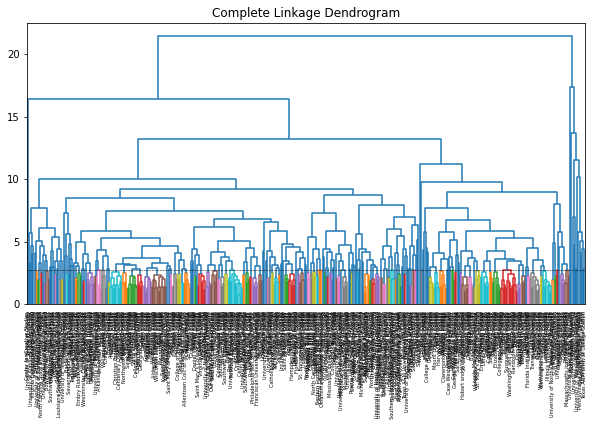

In [412]:
# Reduce to continuous measurements and normalize data
d = pairwise.pairwise_distances(df2, metric='euclidean')
pd.DataFrame(d, columns=df.index, index=df.index).head(5)
df_norm = (df - df.mean())/df.std()
df_norm

# Hierarchical clustering using complete linkage and Euclidean distance 
Z = linkage(df_norm, method='complete')
fig = plt.figure(figsize=(10, 6))
fig.subplots_adjust(bottom=0.23)
plt.title('Complete Linkage Dendrogram')
dendrogram(Z, labels=df_norm.index, color_threshold=2.75)
plt.axhline(y=2.75, color='black', linewidth=0.5, linestyle='dashed')
plt.show()

{'icoord': [[5.0, 5.0, 15.0, 15.0]],
 'dcoord': [[0.0, 21.42904797439613, 21.42904797439613, 0.0]],
 'ivl': ['(458)', '(13)'],
 'leaves': [938, 939],
 'color_list': ['C0']}

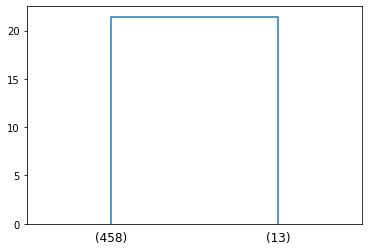

In [416]:
# try splitting into different number of clustesr
dendrogram(Z, labels=df_norm.index,
           color_threshold=2.75,
           truncate_mode = 'lastp', p = 2)

{'icoord': [[15.0, 15.0, 25.0, 25.0], [5.0, 5.0, 20.0, 20.0]],
 'dcoord': [[0.0, 17.384776400150077, 17.384776400150077, 0.0],
  [0.0, 21.42904797439613, 21.42904797439613, 17.384776400150077]],
 'ivl': ['(458)', 'University of Minnesota Twin Cities', '(12)'],
 'leaves': [938, 187, 937],
 'color_list': ['C0', 'C0']}

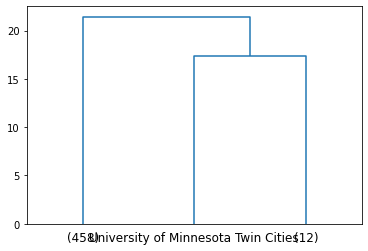

In [417]:
dendrogram(Z, labels=df_norm.index,
           color_threshold=2.75,
           truncate_mode = 'lastp',
           p = 3)

From the dendrogram: How many clusters seem reasonable for describing these data?


Having 2 clusters is reasonable ecause going to three does not yield good results

### 15.1.c
Compare the summary statistics for each cluster and describe each cluster in this context (e.g., "Universities with high tuition, low acceptance rate...").  (_Hint_: To obtain cluster statistics for hierarchical clustering, use the pandas method _groupby(clusterlabel)_ together with methods such as _mean_ or _median_.) 

In [418]:
model = AgglomerativeClustering(n_clusters=2, 
                                affinity = 'euclidean',
                                linkage='complete')
model.fit(df_norm)
labels = model.labels_
df2['clusters'] = labels

ans = df2.groupby(['clusters']).mean()
ans.T

clusters,0,1
# appli. rec'd,17235.231,2747.428
# appl. accepted,11678.385,1790.028
# new stud. enrolled,4207.000,683.452
% new stud. from top 10%,35.154,27.810
% new stud. from top 25%,69.077,55.271
# FT undergrad,20618.538,3078.828
# PT undergrad,4792.692,684.052
in-state tuition,6811.385,9480.299
out-of-state tuition,10435.538,10579.124
room,2464.846,2214.190


### 15.1.d
Use the categorical measurements that were not used in the analysis (State and Private/Public) to characterize the different clusters. Is there any relationship between the clusters and the  categorical information?

In [472]:
df3 = df2[['clusters']].reset_index().merge(
    dforiginal.reset_index(), on='College Name')

In [471]:
#df3.groupby('State')

In [470]:
#print(df3.groupby('State')['clusters'].count())

In [426]:
df3.groupby(['clusters',
             'Public (1)/ Private (2)']).count().sort_values(
    by=['clusters','College Name'],
    ascending=False)

College Name  index  State  # appli. rec'd  \
clusters Public (1)/ Private (2)                                               
1        2                                 371    371    371             371   
         1                                 120    120    120             120   
0        1                                   9      9      9               9   
         2                                   4      4      4               4   

                                  # appl. accepted  # new stud. enrolled  \
clusters Public (1)/ Private (2)                                           
1        2                                     371                   371   
         1                                     120                   120   
0        1                                       9                     9   
         2                                       4                     4   

                                  % new stud. from top 10%  \
clusters Public (1)/ Private (2)                             
1        2                                             368   
         1                                             120   
0        1                                               9   
         2                                               4   

                                  % new stud. from top 25%  # FT undergrad  \
clusters Public (1)/ Private (2)                                             
1        2                                             368             371   
         1                                             120             120   
0        1                                               9               9   
         2                                               4               4   

                                  # PT undergrad  in-state tuition  \
clusters Public (1)/ Private (2)                                     
1        2                                   371               371   
         1                                   120               120   
0        1                                     9                 9   
         2                                     4                 4   

                                  out-of-state tuition  room  board  \
clusters Public (1)/ Private (2)                                      
1        2                                         371   369    365   
         1                                         120   120    120   
0        1                                           9     9      9   
         2                                           4     4      4   

                                  add. fees  estim. book costs  \
clusters Public (1)/ Private (2)                                 
1        2                              364                370   
         1                              120                119   
0        1                                9                  9   
         2                                4                  4   

                                  estim. personal $  % fac. w/PHD  \
clusters Public (1)/ Private (2)                                    
1        2                                      369           371   
         1                                      119           120   
0        1                                        9             9   
         2                                        4             4   

                                  stud./fac. ratio  Graduation rate  
clusters Public (1)/ Private (2)                                     
1        2                                     371              369  
         1                                     120              119  
0        1                                       9                9  
         2                                       4                4

Cluster 2 is predominantly public, cluster 1 private.

In [427]:
df3.groupby(['clusters',
             'State']).count().sort_values(
    by=['clusters','College Name'],
    ascending=False)

College Name  index  Public (1)/ Private (2)  # appli. rec'd  \
clusters State                                                                 
1        PA               42     42                       42              42   
         NY               38     38                       38              38   
         OH               24     24                       24              24   
         NC               23     23                       23              23   
         IL               22     22                       22              22   
         MA               19     19                       19              19   
         TX               19     19                       19              19   
         IA               18     18                       18              18   
         MO               17     17                       17              17   
         IN               16     16                       16              16   
         TN               16     16                       16              16   
         VA               15     15                       15              15   
         CA               14     14                       14              14   
         CT               13     13                       13              13   
         NJ               13     13                       13              13   
         MI               12     12                       12              12   
         MN               12     12                       12              12   
         SC               10     10                       10              10   
         VT               10     10                       10              10   
         WI                9      9                        9               9   
         FL                8      8                        8               8   
         NE                8      8                        8               8   
         DC                7      7                        7               7   
         GA                7      7                        7               7   
         KS                7      7                        7               7   
         KY                7      7                        7               7   
         CO                6      6                        6               6   
         ME                6      6                        6               6   
         NH                6      6                        6               6   
         OK                6      6                        6               6   
         LA                5      5                        5               5   
         MS                5      5                        5               5   
         ND                5      5                        5               5   
         OR                5      5                        5               5   
         SD                5      5                        5               5   
         AL                4      4                        4               4   
         AR                4      4                        4               4   
         RI                4      4                        4               4   
         MD                3      3                        3               3   
         MT                3      3                        3               3   
         WV                3      3                        3               3   
         AK                2      2                        2               2   
         DE                2      2                        2               2   
         ID                2      2                        2               2   
         NM                2      2                        2               2   
         UT                2      2                        2               2   
         WA                2      2                        2               2   
         AZ                1      1                        1               1   
         HI     

### 15.1.e
What other external information can explain the contents of some or all of these clusters?

__Answer__

Private universities carry different traits than public universities, which dramatically impact their tuition and other collegiate attributes which alter the cluster each university belongs to

### 15.1.f
Consider Tufts University, which is missing some information. Compute the Euclidean distance of this record from  each of the clusters that you found above (using only the measurements that you have). Which cluster is it closest to? Impute the missing values for Tufts by taking the average of the cluster on those measurements.

In [488]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(df_norm)

memb = pd.Series(kmeans.labels_, index=df_norm.index)
for key, item in memb.groupby(memb):
     print(key, " ", ', \n'.join(item.index))

0   Alaska Pacific University, 
University of Alaska Southeast, 
Huntingdon College, 
Talladega College, 
University of Alabama at Birmingham, 
John Brown University, 
Harding University, 
Northern Arizona University, 
University of Arizona, 
California Polytechnic-San Luis, 
Southern California College, 
Concordia University, 
Adams State College, 
Fort Lewis College, 
Mesa State College, 
University of Southern Colorado, 
Western State College of Colorado, 
Central Connecticut State University, 
Eastern Connecticut State University, 
University of Connecticut at Storrs, 
University of Delaware, 
Wesley College, 
Bethune Cookman College, 
Embry Riddle Aeronautical University, 
Florida Southern College, 
University of Central Florida, 
Brewton-Parker College, 
University of Georgia, 
Covenant College, 
Savannah Coll. of Art and Design, 
University of Hawaii at Manoa, 
Clarke College, 
Dordt College, 
Graceland College, 
Grand View College, 
Morningside College, 
Mount Mercy College, 
M

In [478]:
# Determine the cluster centroids
centroids = pd.DataFrame(kmeans.cluster_centers_,
                            columns=df_norm.columns)
pd.set_option('precision', 3)
centroids

,# appli. rec'd,# appl. accepted,# new stud. enrolled,% new stud. from top 10%,% new stud. from top 25%,# FT undergrad,# PT undergrad,in-state tuition,out-of-state tuition,room,board,add. fees,estim. book costs,estim. personal $,% fac. w/PHD,stud./fac. ratio,Graduation rate
0,-0.018,0.044,0.113,-0.497,-0.497,0.152,0.200,-0.611,-0.629,-0.385,-0.432,0.033,-0.014,0.302,-0.413,0.383,-0.492
1,0.027,-0.065,-0.167,0.734,0.735,-0.225,-0.295,0.903,0.931,0.569,0.639,-0.049,0.020,-0.447,0.611,-0.566,0.727


In [484]:
# Get information for 'Tufts University' and drop the non continuous variables
tufts = dforiginal.loc[475]
tufts
# Apply the same normalization as for reduced_df
tufts_norm == pd.DataFrame((tufts - df.mean())/df.std())
tufts_norm
# Combine with the centroids information from the clustering
tufts_norm.merge(df3)
df3

,College Name,clusters,index,State,Public (1)/ Private (2),# appli. rec'd,# appl. accepted,# new stud. enrolled,% new stud. from top 10%,% new stud. from top 25%,...,in-state tuition,out-of-state tuition,room,board,add. fees,estim. book costs,estim. personal $,% fac. w/PHD,stud./fac. ratio,Graduation rate
0,Alaska Pacific University,1,0,AK,2,193.0,146.0,55.0,16.0,44.0,...,7560.0,7560.0,1620.0,2500.0,130.0,800.0,1500.0,76.0,11.9,15.0
1,University of Alaska Southeast,1,2,AK,1,146.0,117.0,89.0,4.0,24.0,...,1742.0,5226.0,2514.0,2250.0,34.0,500.0,1162.0,39.0,9.5,39.0
2,Birmingham-Southern College,1,9,AL,2,805.0,588.0,287.0,67.0,88.0,...,11660.0,11660.0,2050.0,2430.0,120.0,400.0,900.0,74.0,14.0,72.0
3,Huntingdon College,1,11,AL,2,608.0,520.0,127.0,26.0,47.0,...,8080.0,8080.0,1380.0,2540.0,100.0,500.0,1100.0,63.0,11.4,44.0
4,Talladega College,1,21,AL,2,4414.0,1500.0,335.0,30.0,60.0,...,5666.0,5666.0,1424.0,1540.0,418.0,1000.0,1400.0,56.0,15.5,46.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499,Univ. of Wisconsin at Eau Claire,1,1274,WI,1,5729.0,4520.0,1957.0,20.0,52.0,...,2208.0,6996.0,1565.0,1140.0,1070.0,279.0,1260.0,80.0,19.3,61.0
500,Wisconsin Lutheran College,1,1283,WI,2,152.0,128.0,75.0,17.0,41.0,...,9100.0,9100.0,1800.0,1900.0,90.0,500.0,1400.0,48.0,8.5,50.0
501,Alderson-Broaddus College,1,1284,WV,2,582.0,498.0,172.0,21.0,44.0,...,10468.0,10468.0,1574.0,1806.0,92.0,660.0,1800.0,40.0,11.5,52.0
502,Marshall University,1,1291,WV,2,4226.0,3666.0,2007.0,14.0,60.0,...,1660.0,5094.0,2030.0,1980.0,330.0,700.0,1560.0,77.0,16.6,50.0


In [485]:
centroids = pd.DataFrame(kmeans.cluster_centers_,
                            columns=df_norm.columns)
pd.set_option('precision', 3)
centroids

,# appli. rec'd,# appl. accepted,# new stud. enrolled,% new stud. from top 10%,% new stud. from top 25%,# FT undergrad,# PT undergrad,in-state tuition,out-of-state tuition,room,board,add. fees,estim. book costs,estim. personal $,% fac. w/PHD,stud./fac. ratio,Graduation rate
0,-0.018,0.044,0.113,-0.497,-0.497,0.152,0.200,-0.611,-0.629,-0.385,-0.432,0.033,-0.014,0.302,-0.413,0.383,-0.492
1,0.027,-0.065,-0.167,0.734,0.735,-0.225,-0.295,0.903,0.931,0.569,0.639,-0.049,0.020,-0.447,0.611,-0.566,0.727


In [486]:
# Calculate distance matrix dropping the columns containing NaN`
pd.DataFrame(pairwise.pairwise_distances(kmeans.cluster_centers_, metric='euclidean'))

,0,1
0,0.000,3.781
1,3.781,0.000


The distance to cluster 1 is 5.06 (normalized), and to cluster 2 it is 7.8. Tufts is closer to cluster 1. We can therefore imput the missing value for `# PT undergrad` in `tufts_norm`.

In [487]:
pd.DataFrame(dforiginal.loc[475])

,475
College Name,Tufts University
State,MA
Public (1)/ Private (2),2
# appli. rec'd,7.61e+03
# appl. accepted,3.60e+03
# new stud. enrolled,1.20e+03
% new stud. from top 10%,60
% new stud. from top 25%,90
# FT undergrad,4.6e+03
# PT undergrad,NaN
